## Global statistical elevation data

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layer
- Querying the data layer
    - Point query
    - Raster query
- References

### Overview

The Global statistical elevation data, also known as GMTED (Global multi-resolution terrain elevation data 2010), primarily relies on the SRTM (Shuttle Radar Topography Mission) data as its core elevation source. However, gaps or voids in the SRTM data are filled using a variety of supplementary datasets, including non-SRTM DTED, Canadian Elevation Data (CDED), SPOT 5 Reference3D, National Elevation Dataset (NED) for the US and Alaska, GEODATA 9-second DEM for Australia, as well as DEMs from Antarctica and Greenland derived from satellite radar and laser altimetry. To integrate these various datasets effectively, the Delta Surface Fill (DSF) method, developed by the National Geospatial-Intelligence Agency (NGA), is employed. The DSF technique adjusts the fill data to align with the SRTM surface at the void interface, ensuring that the filled areas maintain the topographical trends of the original data while preserving valuable characteristics from the supplementary sources.



### Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the config below.

```config.read('../../../../auth/secrets.ini')```

In [1]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
import configparser
import pandas as pd
import ibmpairs.client as client  # represents an authenticated HTTP client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import matplotlib.pyplot as plt
import os
import json
import numpy as np


def now():
    return datetime.datetime.utcnow().isoformat()


print(f"Current time: {now()}")
print("Imports initialized.")

Current time: 2025-01-22T17:26:07.105954
Imports initialized.


### Get authentication token

In [3]:
config = configparser.RawConfigParser()
config.read("../../../../auth/secrets.ini")
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY = config.get("EI", "api.api_key")
EI_TENANT_ID = config.get("EI", "api.tenant_id")
EI_ORG_ID = config.get("EI", "api.org_id")

EI_client_v3 = client.get_client(
    api_key=EI_API_KEY,
    tenant_id=EI_TENANT_ID,
    org_id=EI_ORG_ID,
    legacy=False,
    version=3
)

2025-01-22 22:56:10 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-22 22:56:10 - paw - INFO - Legacy Environment is False
2025-01-22 22:56:10 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-22 22:56:12 - paw - INFO - Authentication success.
2025-01-22 22:56:12 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


### Data layer

Let us start by querying the ibmpairs catalog to retrieve the Data Set ID and the Data Layers that form the Data Set.

In [5]:
# search for datasets by name
filter_catalogue_search_df = catalog.search("Global statistical elevation data")
filter_catalogue_search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,254,49523,Elevation mean,,18,Raster,,Global statistical elevation data,Elevation model that contains a series of stat...


As shown above, the Data Set with ID 254 contains single Data Layer with ID 49523. To gain a better understanding of the Data Set, including its geospatial and temporal coverage, as well as other relevant metadata, we can perform additional queries in the catalog submodule, as outlined in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

### Querying the data layer

#### Point query
Next, let's run a point query for location somewhere in the northern region of Greenland to observe elevation mean data value.

In [11]:
# Submit the query
query_result = query.submit(
    {
        "layers": [
            {
                "type": "raster", 
                "id": "49523"
            }
        ],
        "spatial": {
            "type": "point",
            "coordinates": [
                "80.0716",
                "-70.7718"
            ]  # point in a northern region of Greenland
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2010-01-01T00:00:00Z", 
                    "end": "2010-01-01T23:00:00Z"
                }
            ]
        },
    },
    client=EI_client_v3
)

# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()


# Convert the timestamp to a human readable format as datetime
point_df["datetime"] = pd.to_datetime(point_df["timestamp"] * 1e6, errors="coerce", utc=True)
point_df["datetime"] = point_df["datetime"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df['value'] = point_df['value'].apply(lambda x: '{:.6f}'.format(float(x)))
point_df = point_df.drop(columns=["timestamp"])

# The datetime column will be placed in the middle of the dataFrame, while keeping all other columns in their original order.
datetime_col = "datetime"
columns = point_df.columns.tolist()
columns.remove(datetime_col)
middle_index = len(columns) // 2
columns.insert(middle_index, datetime_col)

point_df = point_df[columns]
point_df

2025-01-16 16:04:03 - paw - INFO - TASK: submit STARTING.
2025-01-16 16:04:08 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,datetime,longitude,latitude,value
0,49523,Elevation mean,Global statistical elevation data,2010-01-01T00:00:00Z,-70.7718,80.0716,403.993683


#### Raster query
Next, we'll perform a raster query for location somewhere in the northern region of Greenland to observe elevation regions.

In [12]:
GMTEDResult = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Global statistical elevation data for region in northern Greenland",
        "spatial": {
            "type": "square",
            "coordinates": [
                80.0716,
                -70.7718,
                81.8093,
                -68.9856
            ],
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2010-01-01T00:00:00Z", 
                    "end": "2010-01-01T23:00:00Z"
                }
            ]
        },
        "layers": [
            {
                "type": "raster", 
                "id": "49523", 
                "output": True
            }
        ]
    },
    client=EI_client_v3
)

2025-01-16 16:05:35 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-16 16:05:37 - paw - INFO - The query was successfully submitted with the id: 1736985600_38137282.
2025-01-16 16:05:39 - paw - INFO - The query 1736985600_38137282 has the status Queued.
2025-01-16 16:06:11 - paw - INFO - The query 1736985600_38137282 has the status Running.
2025-01-16 16:06:43 - paw - INFO - The query 1736985600_38137282 has the status Succeeded.
2025-01-16 16:06:43 - paw - INFO - The query 1736985600_38137282 was successful after checking the status.
2025-01-16 16:07:15 - paw - INFO - The query 1736985600_38137282 has the status Succeeded.
2025-01-16 16:07:15 - paw - INFO - The query 1736985600_38137282 was successful after checking the status.
2025-01-16 16:07:15 - paw - WARNING - The query download folder download was not present on the operating system as either a fixed or relative path. Attempting to create.
2025-01-16 16:07:15 - paw - INFO - The query download folder is se

In [23]:
from PIL import Image

GMTEDResult_file_list = GMTEDResult.list_files()
output_image_array = []
for file in GMTEDResult_file_list:
    if file.endswith(".tiff"):  # display the raster images
        with open(file + ".json", "r") as summary_file:
            fileparms = json.load(summary_file)
        boundingBox = fileparms["boundingBox"]
        pixelStatistics = fileparms["rasterStatistics"]
        # Check if pixelMin and pixelMax are valid (not None)
        if pixelStatistics is not None:
            myextent = [
                boundingBox["minLongitude"],
                boundingBox["maxLongitude"],
                boundingBox["minLatitude"],
                boundingBox["maxLatitude"],
            ]
            arrayGMTED = np.array(Image.open(file))
            mask = arrayGMTED == -9999

            # Masked array to exclude NO Data points from plotting
            masked_array = np.ma.masked_array(arrayGMTED, mask)
            plt.figure(
                figsize=(20, 9), dpi=80
            )  # Sets the size and resolution of the plot
            plt.imshow(
                    masked_array,
                    cmap="terrain",
                    vmin=pixelStatistics["pixelMin"],
                    vmax=pixelStatistics["pixelMax"],
                    extent=myextent,
                )
            
            # Loads the raster data and sets the colormap
            plt.colorbar()  # Adds the color bar
            plt.title(" " + os.path.basename(file))
            # Create a unique output image path using the file name
            output_image_path = os.path.basename(file) + "_image.png"
            output_image_array.append(output_image_path)

            # Save the figure
            plt.savefig(output_image_path, bbox_inches="tight")
            plt.close()

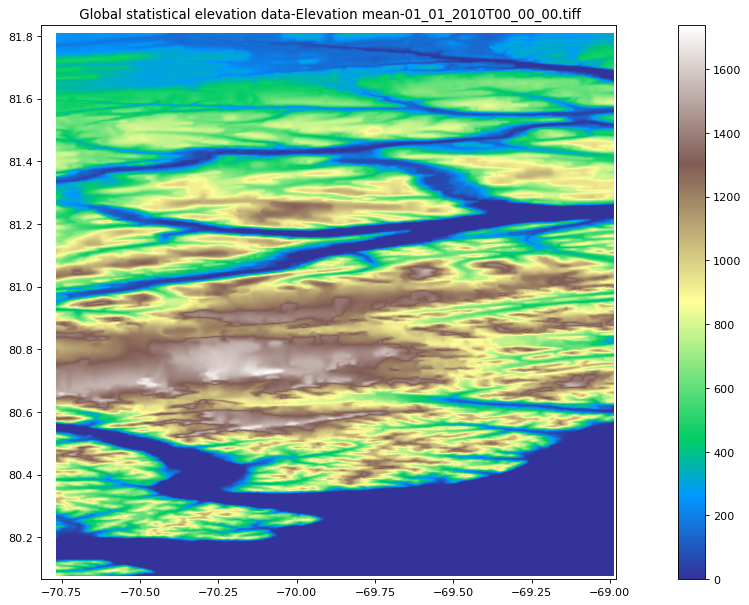

In [24]:
from IPython.display import Image

for output_image in output_image_array:
    # display the raster images
    display(Image(output_image, width=600, height=300))

The raster images above are visualizations of elevation data showing a region's terrain in terms of elevation values. The color bar on the right indicates elevation values in meters where lower elevations are represented by blue or green shades and higher elevations are depicted in yellow, brown, and white. White likely correponds highest elevations, possibly mountaineous regions.   

### References
- https://www.usgs.gov/coastal-changes-and-impacts/gmted2010
- https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-multi-resolution-terrain-elevation